In [13]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import dataio
import modules
from tqdm import tqdm

Define data

In [73]:
sidelength = 256
image_resolution = (512, 512)
split_train = True
batch_size = 1
img_dataset = dataio.Camera()
coord_dataset = dataio.Implicit2DWrapper(img_dataset, sidelength=sidelength, compute_diff='all', split_coord=split_train)
dataloader = DataLoader(coord_dataset, shuffle=True, batch_size=batch_size, pin_memory=True, num_workers=0)

Display Image

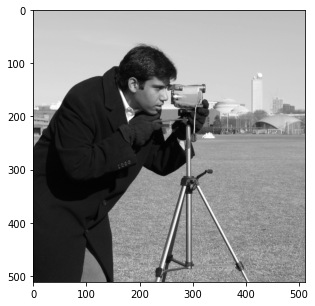

In [74]:
plt.figure(figsize=(5,5))
plt.imshow(img_dataset.img, cmap='gray')

Define Model

In [93]:
model_type = 'sine'
split_mlp = True
approx_layers = 4
fusion_operator = 'prod'
fusion_before_act = False
use_atten = False
learn_code = False
# checkpoint_path = "logs/svd_tests/img_svd_sine_code_orth_loss_L2_0.1_100k_1e-4/checkpoints/model_final.pth"
orth_reg = True
lr = 1e-4
last_layer_features = 128

In [94]:
model = modules.SingleBVPNet(type=model_type, mode='mlp', out_features=img_dataset.img_channels, sidelength=sidelength, 
        split_mlp=split_mlp, approx_layers=approx_layers, fusion_operator=fusion_operator,
        fusion_before_act=fusion_before_act, use_atten=use_atten, learn_code=learn_code, last_layer_features=last_layer_features)
model.cuda()
optim = torch.optim.Adam(lr=lr, params=model.parameters())

{'sidelength': 256, 'approx_layers': 4, 'fusion_operator': 'prod', 'fusion_before_act': False, 'use_atten': False, 'learn_code': False, 'last_layer_features': 128}
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): SplitFCBlock(
    (coord_linears): ModuleList(
      (0): BatchLinear(in_features=1, out_features=256, bias=True)
      (1): BatchLinear(in_features=1, out_features=256, bias=True)
    )
    (coord_nl): Sine()
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=128, bias=True)
      )
    )
  )
)


In [95]:
def image_mse(model_output, gt):
    return {'img_loss': ((model_output['model_out'] - gt['img']) ** 2).mean()}

loss_fn = image_mse

In [96]:
epochs = 5000
steps_til_summary = 500

In [97]:
def apply_cuda(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.cuda()
    else:
        return [t.cuda() for t in tensor]

In [98]:
train_losses = []

Epoch 0, Total loss 0.335369


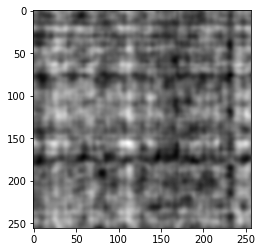

Epoch 500, Total loss 0.003050


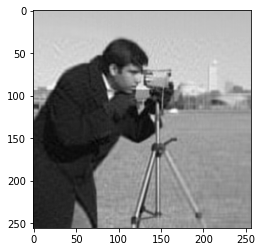

Epoch 1000, Total loss 0.001505


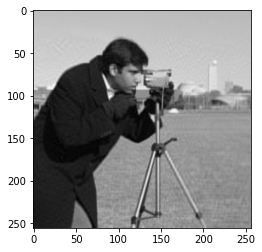

Epoch 1500, Total loss 0.001027


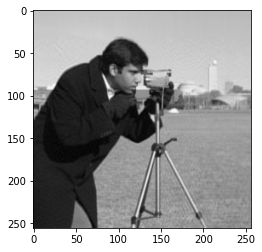

Epoch 2000, Total loss 0.000728


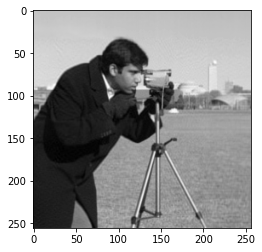

Epoch 2500, Total loss 0.000450


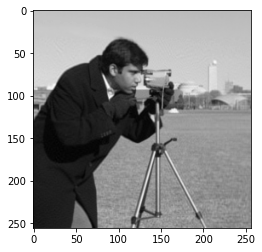

Epoch 3000, Total loss 0.000413


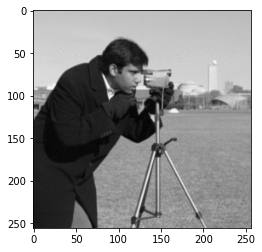

Epoch 3500, Total loss 0.000329


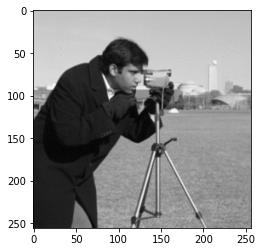

Epoch 4000, Total loss 0.000240


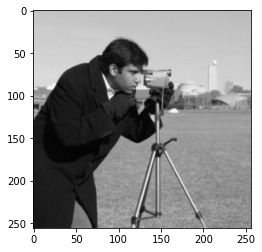

Epoch 4500, Total loss 0.000207


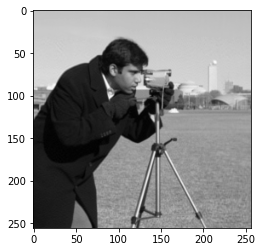

Epoch 5000, Total loss 0.000200


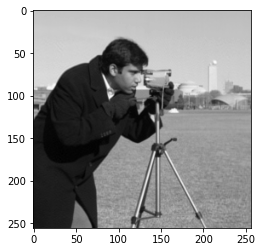

In [99]:
total_steps = 0
# with tqdm(total=epochs) as pbar:
while total_steps <= epochs:
    for step, (model_input, gt) in enumerate(dataloader):
        if total_steps > epochs: break
        model_input = {key: apply_cuda(value) for key, value in model_input.items()}
        gt = {key: apply_cuda(value) for key, value in gt.items()}
        model_output = model(model_input)
        losses = loss_fn(model_output, gt)
        train_loss = 0.
        for loss_name, loss in losses.items():
            single_loss = loss.mean()
            train_loss += single_loss
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        pbar.update(1)
        if not total_steps % steps_til_summary:
            print("Epoch %d, Total loss %0.6f" % (total_steps, train_loss))
            plt.imshow(model_output['model_out'].cpu()\
                       .view(sidelength,sidelength).detach().numpy(), cmap='gray')
            plt.show()
#         pbar.update(1)    
        total_steps += 1
        train_losses.append(train_loss.item())

In [140]:
with torch.no_grad():
    model_output = model(model_input, ret_feat=True)
img_pred, (feat_x, feat_y) = model_output['model_out']
feat_x = feat_x.squeeze(); feat_y = feat_y.squeeze()

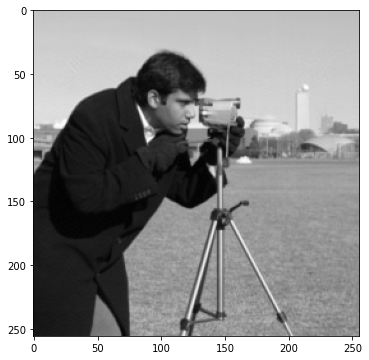

In [101]:
plt.figure(figsize=(6,6))
plt.imshow(img_pred.cpu().view(sidelength,sidelength).detach().numpy(), cmap='gray')

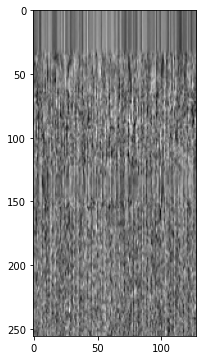

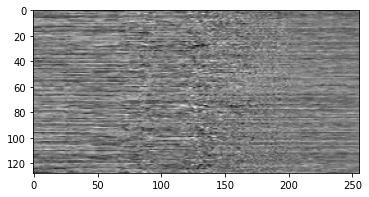

In [102]:
plt.figure(figsize=(3,6))
plt.imshow(feat_x.data.cpu(),  cmap='gray')
plt.figure(figsize=(6,3))
plt.imshow(feat_y.data.cpu().T,  cmap='gray')

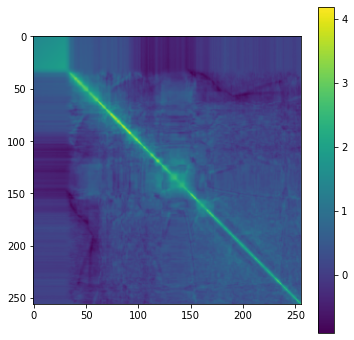

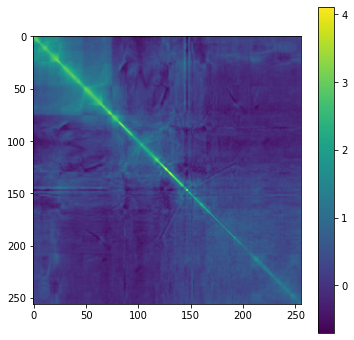

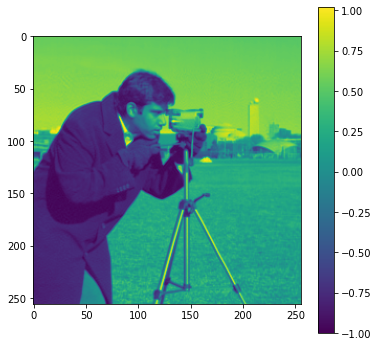

In [107]:
plt.figure(figsize=(6,6))
plt.imshow((feat_x @ feat_x.T).data.cpu())
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow((feat_y @ feat_y.T).data.cpu())
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow((feat_x @ feat_y.T).data.cpu())
plt.colorbar()

In [108]:
import torch
from torch import nn

In [211]:
class EigenEncoder(nn.Module):
    def __init__(self, out_features=256):
        super().__init__()
        self.non_neg = True
        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=64,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(64, 128, 5, 1, 2),     
            nn.ReLU(),           
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(128, 128, 5, 1, 2),     
            nn.ReLU(),    
            nn.MaxPool2d(kernel_size=2),
        )
        # fully connected layer, output 10 classes
        self.linear = nn.Sequential(
            nn.Linear(128*32*32, 256),
            nn.ReLU()
        )
        self.out = nn.Linear(256, out_features)
        self.n_neg_layer = nn.Softplus()
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.conv2(y)
        y = self.conv3(y)
        y = self.linear(y.view(y.size(0), -1))
        y = self.out(y)
        if self.non_neg:
            y = self.n_neg_layer(y)
        return y

In [212]:
class CoordX_SVD(nn.Module):
    def __init__(self, mlp, encoder):
        super().__init__()
        self.mlp = mlp
        self.encoder = encoder
    
    def forward(self, model_input, img):
        code = self.encoder(img.reshape(1, 1, sidelength, sidelength))
        model_output = self.mlp(model_input, ret_feat=True)
        _, (feat_x, feat_y) = model_output['model_out']
        out = (code * feat_x * feat_y).sum(-1).reshape(1,-1,1)
        return {'model_out': (out, (feat_x, feat_y)), 'code': code.squeeze()}

In [213]:
mlp = modules.SingleBVPNet(type=model_type, mode='mlp', out_features=img_dataset.img_channels, sidelength=sidelength, 
        split_mlp=split_mlp, approx_layers=approx_layers, fusion_operator=fusion_operator,
        fusion_before_act=fusion_before_act, use_atten=use_atten, learn_code=learn_code, 
        last_layer_features=256)
encoder = EigenEncoder(out_features=256)
coordx_svd = CoordX_SVD(mlp, encoder).cuda()

{'sidelength': 256, 'approx_layers': 4, 'fusion_operator': 'prod', 'fusion_before_act': False, 'use_atten': False, 'learn_code': False, 'last_layer_features': 256}
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): SplitFCBlock(
    (coord_linears): ModuleList(
      (0): BatchLinear(in_features=1, out_features=256, bias=True)
      (1): BatchLinear(in_features=1, out_features=256, bias=True)
    )
    (coord_nl): Sine()
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
      )
    )
  )
)


In [214]:
optim = torch.optim.Adam(lr=lr, params=coordx_svd.parameters())

In [215]:
def image_svd(model_output, gt):
    img_pred, feats = model_output['model_out']
    feats = [feat.squeeze() for feat in feats]
    return {
        'img_loss': ((img_pred - gt['img']) ** 2).mean(),
        'orth_reg_x': 0.5*torch.square((feats[0] @ feats[0].T) - torch.eye(feats[0].shape[0]).cuda()).mean(),
        'orth_reg_y': 0.5*torch.square((feats[1] @ feats[1].T) - torch.eye(feats[1].shape[0]).cuda()).mean(),
        }
loss_fn = image_svd

In [227]:
epochs = 2000
steps_til_summary = 500

Epoch 0, Total loss 0.000696


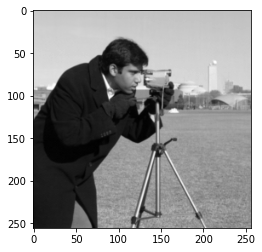

Epoch 500, Total loss 0.000512


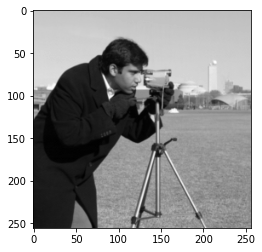

Epoch 1000, Total loss 0.000577


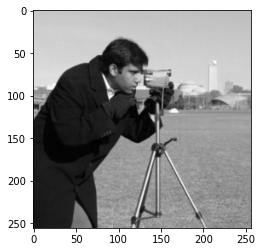

Epoch 1500, Total loss 0.000519


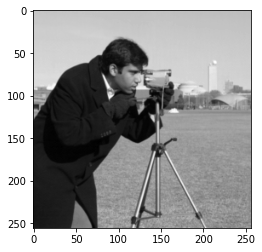

Epoch 2000, Total loss 0.000483


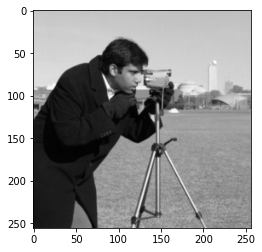

In [228]:
train_losses = []
total_steps = 0
# with tqdm(total=epochs) as pbar:
while total_steps <= epochs:
    for step, (model_input, gt) in enumerate(dataloader):
        if total_steps > epochs: break
        model_input = {key: apply_cuda(value) for key, value in model_input.items()}
        gt = {key: apply_cuda(value) for key, value in gt.items()}
        model_output = coordx_svd(model_input, 
                                gt['img'].reshape(1,1,sidelength, sidelength))
        losses = loss_fn(model_output, gt)
        train_loss = 0.
        for loss_name, loss in losses.items():
            single_loss = loss.mean()
            train_loss += single_loss
        optim.zero_grad()
        train_loss.backward()
        optim.step()
        pbar.update(1)
        if not total_steps % steps_til_summary:
            print("Epoch %d, Total loss %0.6f" % (total_steps, train_loss))
            plt.imshow(model_output['model_out'][0].cpu()\
                       .view(sidelength,sidelength).detach().numpy(), cmap='gray')
            plt.show()
#         pbar.update(1)    
        total_steps += 1
        train_losses.append(train_loss.item())

In [229]:
with torch.no_grad():
    model_output = coordx_svd(model_input, gt['img'].reshape(1,1,sidelength, sidelength))
img_pred, (feat_x, feat_y) = model_output['model_out']
code = model_output['code']
feat_x = feat_x.squeeze(); feat_y = feat_y.squeeze()

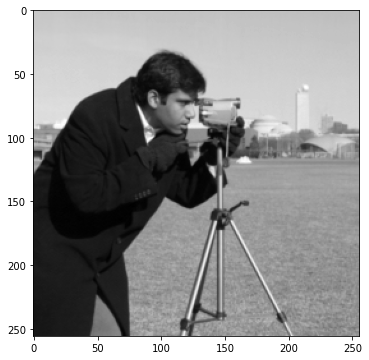

In [230]:
plt.figure(figsize=(6,6))
plt.imshow(img_pred.cpu().view(sidelength,sidelength).detach().numpy(), cmap='gray')

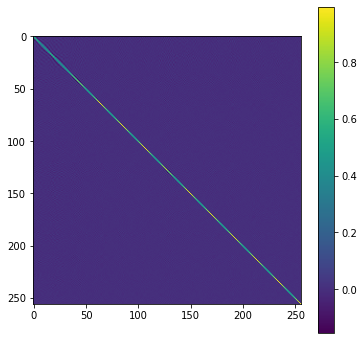

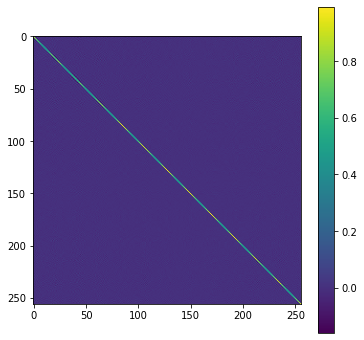

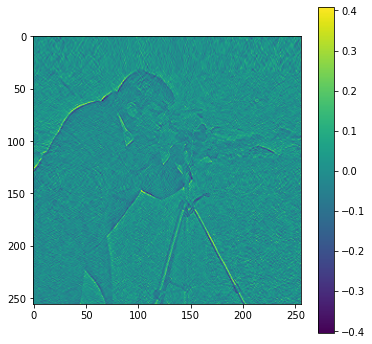

In [231]:
plt.figure(figsize=(6,6))
plt.imshow((feat_x @ feat_x.T).data.cpu())
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow((feat_y @ feat_y.T).data.cpu())
plt.colorbar()
plt.figure(figsize=(6,6))
plt.imshow((feat_x @ feat_y.T).data.cpu())
plt.colorbar()

In [173]:
import numpy as np

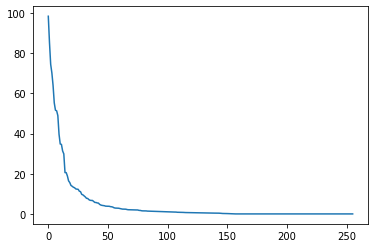

In [232]:
plt.plot(np.sort(code.cpu().numpy())[::-1])

In [175]:
code.shape

torch.Size([1, 256])

Normal SVD

In [192]:
img = coord_dataset.gt_dict['img'].reshape(sidelength,sidelength).numpy()

In [194]:
U,s,VT = np.linalg.svd(img)

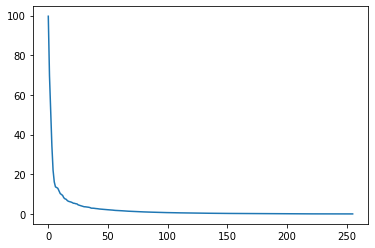

In [195]:
plt.plot(s)

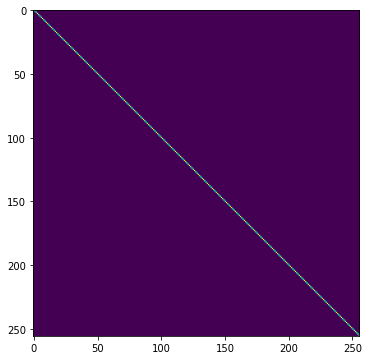

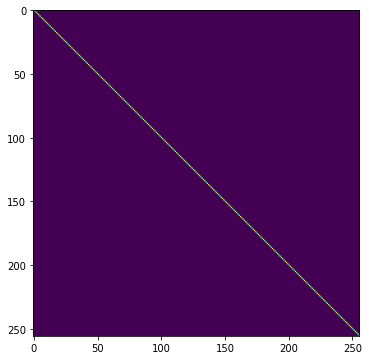

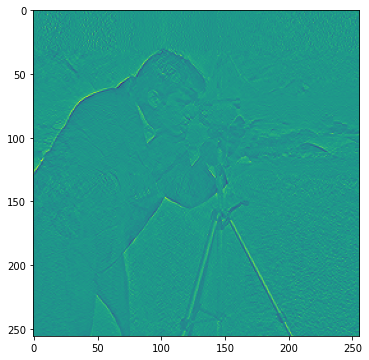

In [196]:
plt.figure(figsize=(6,6))
plt.imshow(U @ U.T)
plt.figure(figsize=(6,6))
plt.imshow(VT.T @ VT)
plt.figure(figsize=(6,6))
plt.imshow(U @ VT)

tensor([2.2050e+09, 8.8308e+07, 4.4666e+01, 9.6251e+06, 9.1287e+08, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 2.9725e+07, 1.0000e+00,
        5.0697e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00, 6.5939e+02, 5.5959e+01,
        1.0000e+00, 1.0790e+32, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.7034e+01,
        1.0000e+00, 3.0917e+00, 1.0000e+00, 8.3654e+07, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 3.2277e+01, 1.0000e+00, 1.3617e+03, 3.3008e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 3.3592e+05, 5.6539e+02, 1.0000e+00, 1.0000e+00,
        6.8235e+00, 1.0000e+00, 1.0000e+00, 3.6235e+00, 8.6531e+08, 1.0000e+00,
        1.0000e+00, 8.1863e+03, 1.0832e+07, 1.0000e+00, 1.2376e+01, 2.1193e+23,
        1.0000e+00, 3.0581e+07, 4.8823e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 2.9308e+00, 3.3064e+00, 1.6484e+05, 5.5357e+00, 5.0594e+00,
        2.3797e+00, 4.6741e+00, 2.1847e+15, 7.0713e+01, 8.8511e+02, 1.6519e+03,
        1.0742e+03, 1.1951e+16, 1.0000e+